In [7]:
import gym
from gym import spaces
import numpy as np

class TrafficEnv(gym.Env):
    """
    Custom Environment for Adaptive Traffic Light Control using Q-Learning
    """

    def __init__(self, max_cars=10):
        super(TrafficEnv, self).__init__()

        # State: number of cars waiting in each direction [N, S, E, W]
        self.observation_space = spaces.Box(low=0, high=max_cars, shape=(4,), dtype=np.int32)

        # Actions: 0 = NS Green (EW Red), 1 = EW Green (NS Red)
        self.action_space = spaces.Discrete(2)

        # Environment parameters
        self.max_cars = max_cars
        self.state = np.zeros(4, dtype=int)
        self.step_count = 0
        self.max_steps = 200

    def reset(self):
        self.state = np.random.randint(0, 3, size=4)
        self.step_count = 0
        return self.state

    def step(self, action):
        """
        Execute one time step
        """
        self.step_count += 1
        cars = self.state.copy()

        # Cars pass depending on green light
        if action == 0:
            # NS Green: cars in North & South decrease
            cars[0] = max(0, cars[0] - np.random.randint(1, 3))
            cars[1] = max(0, cars[1] - np.random.randint(1, 3))
        else:
            # EW Green
            cars[2] = max(0, cars[2] - np.random.randint(1, 3))
            cars[3] = max(0, cars[3] - np.random.randint(1, 3))

        # New cars arrive randomly
        new_arrivals = np.random.randint(0, 3, size=4)
        cars = np.minimum(self.max_cars, cars + new_arrivals)

        self.state = cars

        # Reward: negative total waiting cars
        reward = -np.sum(self.state)

        # Done when max steps reached
        done = self.step_count >= self.max_steps

        info = {}

        return self.state, reward, done, info

    def render(self):
        print(f"Step: {self.step_count} | State (N,S,E,W): {self.state}")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [8]:
import numpy as np
import random

env = TrafficEnv()
state_size = tuple(env.observation_space.shape)[0]
action_size = env.action_space.n

# Q-table
Q = np.zeros((env.max_cars+1, env.max_cars+1, env.max_cars+1, env.max_cars+1, action_size))

# Parameters
episodes = 1000
alpha = 0.1
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01

def get_q_state(state):
    return tuple(state)

for ep in range(episodes):
    state = env.reset()
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[get_q_state(state)])

        next_state, reward, done, _ = env.step(action)

        # Q-learning update
        Q[get_q_state(state)][action] += alpha * (
            reward + gamma * np.max(Q[get_q_state(next_state)]) - Q[get_q_state(state)][action]
        )

        state = next_state

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

print("Training finished ✅")


Training finished ✅


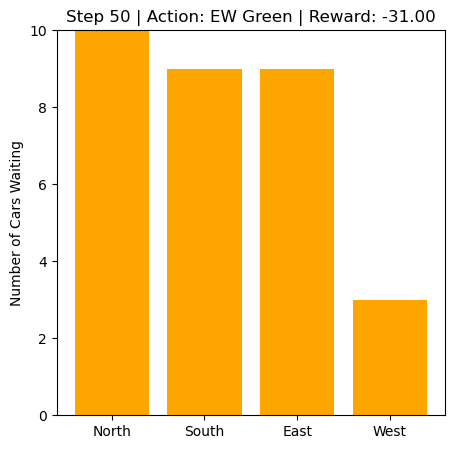

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

state = env.reset()
done = False

for step in range(50):
    clear_output(wait=True)
    action = np.argmax(Q[get_q_state(state)])
    next_state, reward, done, _ = env.step(action)

    plt.figure(figsize=(5, 5))
    plt.bar(['North', 'South', 'East', 'West'], env.state, color='orange')
    plt.title(f"Step {step+1} | Action: {'NS Green' if action == 0 else 'EW Green'} | Reward: {reward:.2f}")
    plt.ylim(0, env.max_cars)
    plt.ylabel("Number of Cars Waiting")
    plt.show()

    time.sleep(0.5)
    state = next_state

plt.close()
